En este notebook se ven cosas que sobraron como porqué los w's de 0 y 1 no daban valores distintos

# CD plots

Los CD plots del [repositorio](https://github.com/hfawaz/cd-diagram) tenían dos problemas con respecto a este trabajo:

1. Usaban primero la prueba de Friedman para ver si había diferencias significativas para algún miembro y luego hacían la de wilcoxon
2. Hacían la prueba de wilcoxon simétrica, dando igual peso a si la distribución era menor o mayor y aquí nos importa que sea mayor o menos dependiendo de lo que querrámos optimizar. 

Por esto cambiamos la función y la pusimos en `utils/cd_plot.py` para 

In [1]:
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from utils.func_aux import *
from utils.func_vis import *
from utils.cd_plots import *
import plotly.express as px
import pandas as pd
import numpy as np
import networkx as nx
import os


# Opciones de matplotlib
rc = plt.rcParams
rc["figure.figsize"] = [15, 5]

# Para mostrar todas las columnas cuando se imprime un df
pd.set_option("display.max_columns", None)

# Para poner el estilo de las gráficas de matplotlib parecido al de ggplot
plt.style.use("ggplot") 

go_to_Assesment()

In [2]:
go_to_Assesment()
df_borda=pd.read_csv('../tablas_generadas/conteo_borda.csv')
df_borda=df_borda.set_index(['n_objetivos','problema','indicador'])

df_problemas=pd.read_csv('../tablas_generadas/problemas_prueba.csv')
df_problemas=df_problemas[(~df_problemas['problemas'].str.startswith('ZDT'))&(df_problemas['n_obj']<10)]

df_todos_PI_signo=pd.read_csv('../tablas_generadas/todos_QI_maximizados.csv')

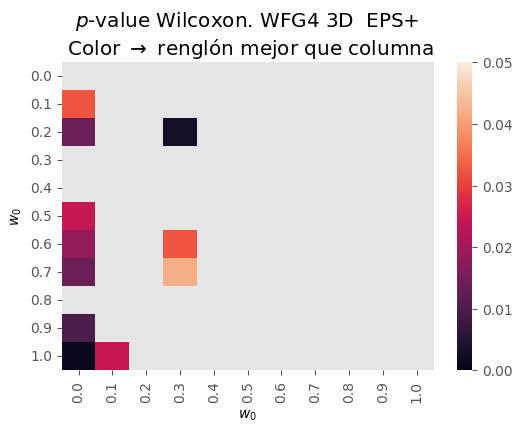

In [20]:
problema='WFG4'
n_objetivos=3
indicador='eps+'

df_todos_PI_IGDp_signo=df_todos_PI_signo.query('divers_QI=="IGD+"')
get_heatmap(problema=problema,n_objetivos=n_objetivos,indicador=indicador,df_todos_PI=df_todos_PI_IGDp_signo,df_WC=df_WC_IGDp);

# CD plots exploración

Ver con un conjunto de datos sintético exactamente que se está graficando en cada caso. Modificar la función para que pueda o no hacer la corrección de Holm, Bonferroni, etc y pueda o no hacer la primera prueba de Friedman o ANOVA o Kruskal-Wallis.

Ver este [video](https://www.youtube.com/watch?v=kpTvTyMcDqY) para entender bien lo de Bonferroni

Tomamos un heatmap de un problema y un indicador, le aplicamos las pruebas de arriba y vemos que dé algo parecido.

Primero hay que pasarlo a la notación de la librería, en la cual se tienen tres columnas:

- classifier_name : El nombre del algoritmo distinto. Por ejemplo, las diferentes combinaciones de pesos del algoritmo PFI-EMOA.
- dataset_name: El conjunto inicial de datos que se le da al algoritmo. En nuestro caso las diferentes semillas o runs.
- accuracy : El valor a comparar, que sería un indicador o varios, el punto es que estén alineados para que se haga una comparación rankeable

[['0.4', '0.8', '0.001', '0.3'],
 ['0.4', '0.8', '0.5', '0.9', '0.3', '0.999'],
 ['0.4', '0.8', '0.5', '0.9', '0.3', '0.1'],
 ['0.4', '0.8', '0.5', '0.9', '0.7', '0.6', '0.2', '0.999'],
 ['0.4', '0.8', '0.5', '0.9', '0.7', '0.6', '0.2', '0.1']]

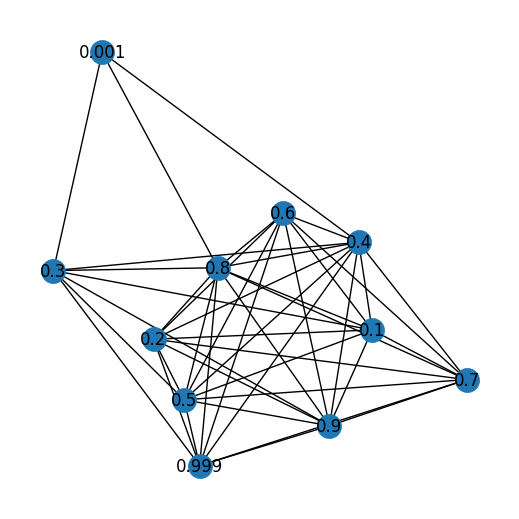

In [23]:
def form_cliques_draw(p_values, nnames):
    """
    This method forms the cliques
    """
    # first form the numpy matrix data
    m = len(nnames)
    g_data = np.zeros((m, m), dtype=np.int64)
    for p in p_values:
        clas_i=p[0]
        clas_j=p[1]

        prueba_ij=p[3]
        prueba_ji=[x[3] for x in p_values if (x[0]==clas_j and x[1]==clas_i)][0]
        if prueba_ij==False and prueba_ji== False:
            i = np.where(nnames == p[0])[0][0]
            j = np.where(nnames == p[1])[0][0]
            min_i = min(i, j)
            max_j = max(i, j)
            g_data[min_i, max_j] = 1

    g = nx.Graph(g_data)
    g= nx.relabel_nodes(g,{i:nnames[i] for i in range(len(nnames))})
    return g, nx.find_cliques(g)

p_values,average_ranks,_ = wilcoxon_holm(df_perf=get_df_CD(problema,n_objetivos,indicador,df_PI=df_todos_PI_IGDp_signo),alternative='greater')
g,cliques=form_cliques_draw(p_values,nnames=average_ranks.keys())
plt.figure(figsize=(5,5))
nx.draw(g,with_labels=True)
list(cliques)

dibujamos el CD diagram en este caso

WFG4 3 eps+


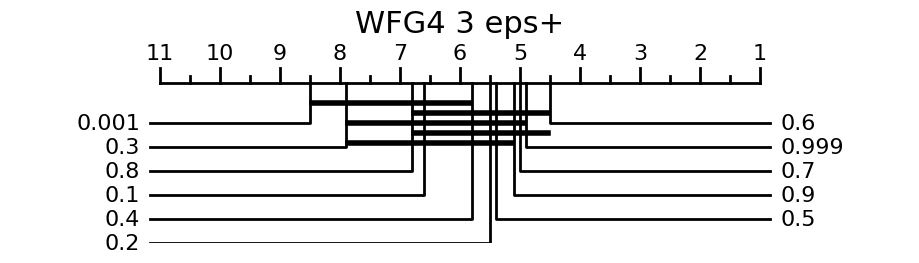

In [25]:
draw_cd_diagram(df_perf=get_df_CD(problema,n_objetivos,indicador,df_PI=df_todos_PI_IGDp_signo),alternative='greater',title=f'{problema} {n_objetivos} {indicador}',save=False);

# Dibujamos gráficas

Dibujamos los CD plots de todos los que tengan al menos una diferencia significativa.

In [1]:
# indicadores=df_borda.reset_index().indicador.unique()

# for dim,prob,ind in df_borda[df_borda.sum(axis=1)!=0].index:
#     try:
#         draw_cd_diagram(df_perf=get_df_CD(prob,dim,ind,df_PI=df_todos_PI_IGDp),title=f'{prob} {dim} {ind}',path='../CD_plots_imgs/problemas_individuales')
#     except:
#         print('Error en:\n',dim,prob,ind)


Para hacer otras agregaciones podemos expandir los datasets de modo que el algoritmo sigue siendo $w_0$, pero ahora hay un dataset por cada

- n_objetivos y run para un problema fijo.

- problema y el run para una dimensión fija

- el problema la n_objetivos y el run y comparar todos vs todos para un indicador de diversidad fijo

- Problema, dimensión, run e indicador de diversidad 

Primero pasamos los indicadores que se minimizan a negativos y seguimos comparando con la prueba `greater`. También generamos boxplots para asegurarnos que estemos graficando lo correcto

In [2]:
go_to_Assesment()
df_todos_PI=pd.read_csv('../tablas_generadas/todos_QI.csv')

def maximizar_los_minimizados(row):
    if dicc_indicadores[row['indicador']]=='Minimize':
        row['valor_indicador']=-row['valor_indicador']
    return row

# df_todos_PI_signo=df_todos_PI.apply(maximizar_los_minimizados,axis=1)
# df_todos_PI_signo.to_csv('../tablas_generadas/todos_QI_maximizados.csv',index=False)
df_todos_PI_signo=pd.read_csv('../tablas_generadas/todos_QI_maximizados.csv')
df_todos_PI_signo

,problema,indicador,w_0,n_objetivos,run,valor_indicador,divers_QI
0,WFG9,eps+,0.001,3,0,-0.217718,IGD+
1,WFG9,eps+,0.001,3,1,-0.240986,IGD+
2,WFG9,eps+,0.001,3,2,-0.240616,IGD+
3,WFG9,eps+,0.001,3,3,-0.236098,IGD+
4,WFG9,eps+,0.001,3,4,-0.267390,IGD+
...,...,...,...,...,...,...,...
147835,WFG9,hv,0.999,6,5,93347.990000,R2
147836,WFG9,hv,0.999,6,6,97336.020000,R2
147837,WFG9,hv,0.999,6,7,95928.310000,R2
147838,WFG9,hv,0.999,6,8,98113.420000,R2


In [3]:
df_todos_PI_IDGp_signo=df_todos_PI_signo.query('divers_QI=="IGD+"')
df_todos_PI_IDGp_signo

,problema,indicador,w_0,n_objetivos,run,valor_indicador,divers_QI
0,WFG9,eps+,0.001,3,0,-0.217718,IGD+
1,WFG9,eps+,0.001,3,1,-0.240986,IGD+
2,WFG9,eps+,0.001,3,2,-0.240616,IGD+
3,WFG9,eps+,0.001,3,3,-0.236098,IGD+
4,WFG9,eps+,0.001,3,4,-0.267390,IGD+
...,...,...,...,...,...,...,...
73915,WFG9,hv,0.999,6,5,96350.260000,IGD+
73916,WFG9,hv,0.999,6,6,97720.000000,IGD+
73917,WFG9,hv,0.999,6,7,98557.950000,IGD+
73918,WFG9,hv,0.999,6,8,98565.140000,IGD+


No importa que salgan así?

In [30]:
problema='WFG4' 
df_part=df_todos_PI_IGDp_signo.query(f'problema=="{problema}"')
df_problema=pd.DataFrame({'classifier_name':df_part['w_0'],'dataset_name':df_part['indicador']+df_part['n_objetivos'].astype(str)+df_part['run'].astype(str),'accuracy':df_part['valor_indicador']})
px.box(df_problema,x='classifier_name',y='accuracy')

In [2]:
# # Problema fijo dataset sobre todas las n_objetivoses

# for problema in df_problemas.problemas.unique():
#     df_part=df_todos_PI_IGDp_signo.query(f'problema=="{problema}"')
#     df_problema=pd.DataFrame({'classifier_name':df_part['w_0'],'dataset_name':df_part['indicador']+df_part['n_objetivos'].astype(str)+df_part['run'].astype(str),'accuracy':df_part['valor_indicador']})
#     draw_cd_diagram(df_perf=df_problema,title=problema,path='../CD_plots_imgs/problemas_todas_n_objetivoses')
 

In [3]:
# # Para una dimensión fija
# for n_objetivos in df_problemas.n_obj.unique():
#     df_part=df_todos_PI_IGDp_signo.query(f'n_objetivos=={n_objetivos}')
#     df_agrup=pd.DataFrame({'classifier_name':df_part['w_0'],'dataset_name':df_part['indicador']+df_part['problema'].astype(str)+df_part['run'].astype(str),'accuracy':df_part['valor_indicador']})
#     try:
#         draw_cd_diagram(df_perf=df_agrup,title=n_objetivos,path='../CD_plots_imgs/n_objetivos')
#     except:
#         print('Error en \n', n_objetivos)

Todos_problemas_IGDp


/home/scented_meat/Tesis-LCD/utils/cd_plots.py:484: RuntimeWarning:

invalid value encountered in subtract

/home/scented_meat/.local/lib/python3.8/site-packages/scipy/stats/_morestats.py:3397: RuntimeWarning:

invalid value encountered in subtract



Archivo guardado en ../CD_plots_imgs//Todos_problemas_IGDp_cd_diagram.png


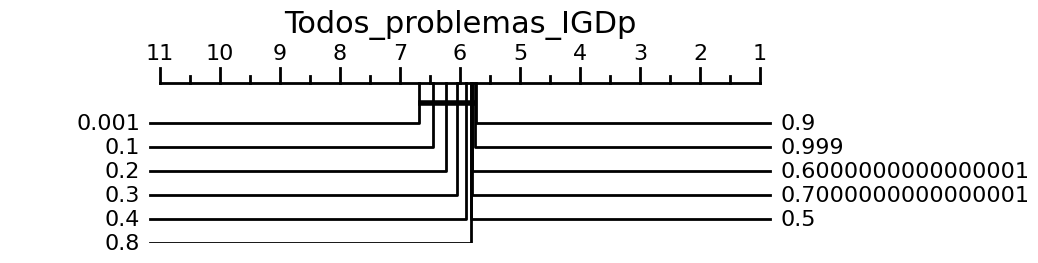

In [35]:
# Para todos los problemas 

df_part=df_todos_PI_IGDp_signo.copy()
df_agrup=pd.DataFrame({'classifier_name':df_part['w_0'],'dataset_name':df_part['indicador']+df_part['problema'].astype(str)+df_part['n_objetivos'].astype(str)+df_part['run'].astype(str),'accuracy':df_part['valor_indicador']})
draw_cd_diagram(df_perf=df_agrup,title='Todos_problemas_IGDp',path='../CD_plots_imgs/')

Ahora vemos entre el R2 e IGD+ si hay diferencia en algún ejemplo

### Por cada uno de los w_i cuál es mejor

In [4]:

# for w00 in df_todos_PI.w_0.unique():
#     df_part=df_todos_PI_signo.query(f'w_0=={w00}')
#     df_agrup=pd.DataFrame({'classifier_name':df_part['divers_QI'],'dataset_name':df_part['indicador']+df_part['problema'].astype(str)+df_part['n_objetivos'].astype(str)+df_part['run'].astype(str),'accuracy':df_part['valor_indicador']})
#     draw_cd_diagram(df_perf=df_agrup,title=w00,path='../CD_plots_imgs/R2_vs_IGDp_ws')


Por cada problema, dimensión e indicador. Cuál es mejor?

In [5]:
# for dim,prob,ind in df_borda[df_borda.sum(axis=1)!=0].index:
#     df_part=df_todos_PI_IGDp_signo.query(f'(problema=="{prob}") & (n_objetivos=={dim}) & (indicador=="{ind}")')
#     df_agrup=pd.DataFrame({'classifier_name':df_part['divers_QI'],'dataset_name':df_part['w_0'].astype(str)+df_part['run'].astype(str),'accuracy':df_part['valor_indicador']})
#     draw_cd_diagram(df_perf=df_agrup,title=f'{prob} {dim} {ind}',path='../CD_plots_imgs/R2_vs_IGDp_prob_dim_ind')
# # df_agrup


Obtenemos una lista de victorias o igualdades entre R2 e IGD + para cada problema, n_objetivos, indicador

In [12]:
QI_tabla=pd.read_csv('../tablas_generadas/QI_carac.csv')

dicc_indicadores={QI_tabla.indicador[i]:QI_tabla.Meta[i] for i in range(len(QI_tabla))}
dicc_indicadores

{'igd+': 'Minimize',
 'r2': 'Maximize',
 's-energy': 'Maximize',
 'eps+': 'Minimize',
 'igd': 'Minimize',
 'spd': 'Maximize',
 'hv': 'Maximize'}

In [52]:
def get_WC_R2_IGDp(df):
    prob,ind,dim,w_0=df.name
   


    x=df[df['divers_QI']=='IGD+']['valor_indicador']
    y=df[df['divers_QI']=='R2']['valor_indicador']
    # res_xy=st.wilcoxon(x,y,alternative='greater')[1]
    # res_yx=st.wilcoxon(y,x,alternative='greater')[1]
    # return pd.Series(data=[res_xy,res_yx],index=['IGD+','R2'])
    try:
        res_xy=st.wilcoxon(x,y,alternative='greater')[1]
        res_yx=st.wilcoxon(y,x,alternative='greater')[1]
        return pd.Series(data=[res_xy,res_yx],index=['IGD+','R2'])
    except: 
        return pd.Series(data=[np.nan,np.nan],index=['IGD+','R2'])
    

df_WC_R2_IGDp=df_todos_PI_signo.groupby(['problema','indicador','n_objetivos','w_0']).apply(get_WC_R2_IGDp)

/home/scented_meat/.local/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning:

Exact p-value calculation does not work if there are zeros. Switching to normal approximation.

/home/scented_meat/.local/lib/python3.8/site-packages/scipy/stats/_morestats.py:3428: UserWarning:

Sample size too small for normal approximation.

/home/scented_meat/.local/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning:

Exact p-value calculation does not work if there are zeros. Switching to normal approximation.

/home/scented_meat/.local/lib/python3.8/site-packages/scipy/stats/_morestats.py:3428: UserWarning:

Sample size too small for normal approximation.

/home/scented_meat/.local/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning:

Exact p-value calculation does not work if there are zeros. Switching to normal approximation.

/home/scented_meat/.local/lib/python3.8/site-packages/scipy/stats/_morestats.py:3428: UserWarning:

Sample size to

In [54]:
px.box(data_frame=df_todos_PI.query('(problema=="WFG9") & (indicador=="spd") & (n_objetivos==7) & (w_0==0.999)'),x='divers_QI',y='valor_indicador')

Aca hace falta dividir entre problemas, n_objetivoses, tipo de problemas, etc.

In [4]:
go_to_Assesment()
df_WC_R2_IGDp=pd.read_csv('../tablas_generadas/WC_QI_R2_IGDp_signo.csv')
df_WC_R2_IGDp[['IGD+','R2']]=df_WC_R2_IGDp[['IGD+','R2']]<0.05
df_WC_R2_IGDp

,problema,indicador,n_objetivos,w_0,IGD+,R2
0,DTLZ1,eps+,2,0.001,False,True
1,DTLZ1,eps+,2,0.100,False,True
2,DTLZ1,eps+,2,0.200,False,True
3,DTLZ1,eps+,2,0.300,False,True
4,DTLZ1,eps+,2,0.400,False,True
...,...,...,...,...,...,...
7387,WFG9,spd,7,0.600,True,False
7388,WFG9,spd,7,0.700,True,False
7389,WFG9,spd,7,0.800,True,False
7390,WFG9,spd,7,0.900,True,False


## Total de victorias

In [8]:
fig=px.bar(100*df_WC_R2_IGDp[['IGD+','R2']].sum()/len(df_WC_R2_IGDp))
fig.update_layout(
    # title='Victorias de cada uno de los métodos',
    xaxis_title='indicador de convergencia', yaxis_title='Porcentaje de victorias',
    height=400, width=400,showlegend=False
)
# fig.layout.yaxis.tickformat = ',.0%' 
fig.write_image('../imgs_pdf/R2_vs_IGDp.pdf')
fig.show()


# Victorias por dimensión

El número total de comparaciones es de num_problemas con n_objetivos* numero de w_i's

In [9]:
df_WC_R2_IGDp['No se rechaza H0']=((~(df_WC_R2_IGDp['R2']) & ~(df_WC_R2_IGDp['IGD+'])))
df_WC_melt=pd.melt(df_WC_R2_IGDp, id_vars=['problema','n_objetivos', 'indicador','w_0'], value_vars=['IGD+', 'R2', 'No se rechaza H0'], var_name='indicador_diversidad', value_name='victoria')
df_WC_melt.to_csv('../tablas_generadas/WC_melt_R2_IGDp_signo.csv',index=False)

In [10]:
n_problemas=df_problemas[(df_problemas['n_obj']==2)].problemas.nunique()
n_wi=df_todos_PI.w_0.nunique()
df_agreg= df_WC_R2_IGDp.groupby(['n_objetivos','indicador'])[['IGD+','R2']].sum()
df_agreg['No se rechaza H0']=n_problemas*n_wi-df_agreg.sum(axis=1)
df_agreg=(df_agreg/(n_problemas*n_wi)).reset_index()
df_agreg

,n_objetivos,indicador,IGD+,R2,No se rechaza H0
0,2,eps+,0.420455,0.085227,0.494318
1,2,hv,0.375000,0.056818,0.568182
2,2,igd,0.346591,0.085227,0.568182
3,2,igd+,0.386364,0.051136,0.562500
4,2,r2,0.329545,0.039773,0.630682
5,2,s-energy,0.755682,0.125000,0.119318
6,2,spd,0.511364,0.062500,0.426136
7,3,eps+,0.454545,0.073864,0.471591
8,3,hv,0.590909,0.096591,0.312500
9,3,igd,0.670455,0.039773,0.289773


In [11]:
df_melted = pd.melt(df_agreg, id_vars=['n_objetivos', 'indicador'], value_vars=['IGD+', 'R2', 'No se rechaza H0'], var_name='victoria', value_name='% victoria')
df_melted

,n_objetivos,indicador,victoria,% victoria
0,2,eps+,IGD+,0.420455
1,2,hv,IGD+,0.375000
2,2,igd,IGD+,0.346591
3,2,igd+,IGD+,0.386364
4,2,r2,IGD+,0.329545
...,...,...,...,...
121,7,igd,No se rechaza H0,0.232955
122,7,igd+,No se rechaza H0,0.363636
123,7,r2,No se rechaza H0,0.443182
124,7,s-energy,No se rechaza H0,0.198864


In [9]:
for dim in df_agreg.n_objetivos.unique():
    df_px=df_melted.query(f'n_objetivos=={dim}')
    fig=px.bar(df_px,x='indicador',y='% victoria',color='victoria',barmode='group')
    fig.update_layout(
        # title=f'R2 vs IGD+ para {dim} objetivos',
        height=500, width=900
    )
    fig.layout.yaxis.tickformat = ',.0%' 
    fig.write_image(f'../imgs_pdf/R2_vs_IGDp_nobj{dim}.pdf')
    fig.show()

In [16]:
df_WC_melt=df_WC_melt.rename(columns={'indicador_diversidad':'divers_QI'})
df_WC_melt

,problema,n_objetivos,indicador,w_0,divers_QI,victoria
0,DTLZ1,2,eps+,0.001,IGD+,False
1,DTLZ1,2,eps+,0.100,IGD+,False
2,DTLZ1,2,eps+,0.200,IGD+,False
3,DTLZ1,2,eps+,0.300,IGD+,False
4,DTLZ1,2,eps+,0.400,IGD+,False
...,...,...,...,...,...,...
22171,WFG9,7,spd,0.600,No se rechaza H0,False
22172,WFG9,7,spd,0.700,No se rechaza H0,False
22173,WFG9,7,spd,0.800,No se rechaza H0,False
22174,WFG9,7,spd,0.900,No se rechaza H0,False


In [15]:
df_agreg=df_WC_melt.groupby(['n_objetivos','divers_QI'])['victoria'].mean().reset_index()
fig=px.bar(data_frame=df_agreg,x='n_objetivos',y='victoria',color='divers_QI',barmode='group')
fig.layout.yaxis.tickformat = ',.0%' 
fig.update_layout(
    # title='R2 vs IGD con número de objetivos',
    xaxis_title='Objetivos',
    height=500, width=900
)
fig.write_image('../imgs_pdf/R2_vs_IGDp_con_num_obj.pdf')
fig.show()

## Por característica del indicador

In [20]:
QI_carac=pd.read_csv('../tablas_generadas/QI_carac.csv')

In [21]:
df_melt_carac=pd.merge(left=df_WC_melt,right=QI_carac,on='indicador')

df_agreg=df_melt_carac.groupby(['Categoría','divers_QI']).victoria.mean().reset_index()
fig=px.bar(data_frame=df_agreg,x='Categoría',y='victoria',color='divers_QI',barmode='group')
fig.layout.yaxis.tickformat = ',.0%' 
fig.update_layout(
    # title='R2 vs IGD+ por tipo de indicador',
     yaxis_title='% de Victorias',
    height=500, width=900
)
fig.write_image('../imgs_pdf/R2_vs_IGDp_por_tipo_ind.pdf')
fig.show()


# Demostración de que $w_0=0$ y $w_0=1$ da lo mismo

leemos de los de WC para ver uno en el que haya una gran diferencia

In [11]:
df_borda=pd.read_csv('../tablas_generadas/conteo_borda_todos.csv')

df_borda.loc[df_borda.groupby(['n_objetivos','problema','indicador']).apply(lambda df: df.max(axis=1)).reset_index()[0].argmax()]
# .max(axis=1)

/tmp/ipykernel_276/213391673.py:3: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



n_objetivos        3
problema     DTLZ2
indicador      spd
divers_QI     IGD+
0               10
1                7
2                6
3                3
4                3
5                3
6                0
7                2
8                1
9                0
10               0
Name: 250, dtype: object

In [6]:
def diag_probl(problema,n_objetivos,df_PI, ind_conv='IGDp',aggfunc='mean',indicador='HV',run=0):
    '''Regresa los pairplots, los boxplots y la tabla del indicador pedido'''
    plot_prob(problema,n_objetivos,problema,run,ind_conv=ind_conv)
    get_boxplot(problema,n_objetivos,indicador,df_PI=df_PI)
    
    return get_tabla(indicador,df_PI,aggfunc=aggfunc)

Se encontró el conjunto de referencia en Assessment


w_0                      0.001       0.100       0.200       0.300  \
problema n_objetivos                                                   
DTLZ1    2            4.537413    4.535772    4.536557    4.537305   
         3            9.335778    9.336932    9.324543    9.327623   
         4           14.439467   14.467203   14.497346   14.429191   
         5           19.093972   19.891195   19.670532   19.480485   
         6           26.961637   27.689463   27.306640   25.144051   
...                        ...         ...         ...         ...   
WFG9     3          111.655950  111.719180  111.797290  111.862250   
         4          119.849480  119.851370  119.847380  119.854090   
         5          119.994430  119.993980  119.995460  119.995210   
         6          119.999760  119.999840  119.999590  119.999700   
         7          120.000000  120.000000  119.999980  119.999990   

w_0                      0.400       0.500       0.600       0.700  \
problema n_objetivos                                                   
DTLZ1    2            4.536482    4.536120    4.535513    4.535353   
         3            9.323562    9.327864    9.324253    9.319503   
         4           14.389458   14.384274   14.405437   14.428090   
         5           19.785522   18.963615   19.504831   18.557618   
         6           23.120832   23.221216   23.949530   22.621986   
...                        ...         ...         ...         ...   
WFG9     3          111.654790  111.642320  111.612490  111.487140   
         4          119.851510  119.845510  119.815870  119.818200   
         5          119.994720  119.993600  119.992630  119.994210   
         6          119.999860  119.999660  119.999760  119.999620   
         7          120.000000  119.999980  119.999990  119.999960   

w_0                      0.800       0.900       0.999  
problema n_objetivos                                      
DTLZ1    2            4.535531    4.535836    4.536089  
         3            9.322827    9.318700    9.323497  
         4           13.981685   14.410489   14.389744  
         5           18.959774   19.510462   19.446031  
         6           23.164853   22.855454   23.360168  
...                        ...         ...         ...  
WFG9     3          111.504440  111.274030  111.272510  
         4          119.824860  119.828240  119.827340  
         5          119.994620  119.994420  119.993800  
         6          119.999690  119.999570  119.999670  
         7          120.000000  120.000000  119.999970  

[96 rows x 11 columns]

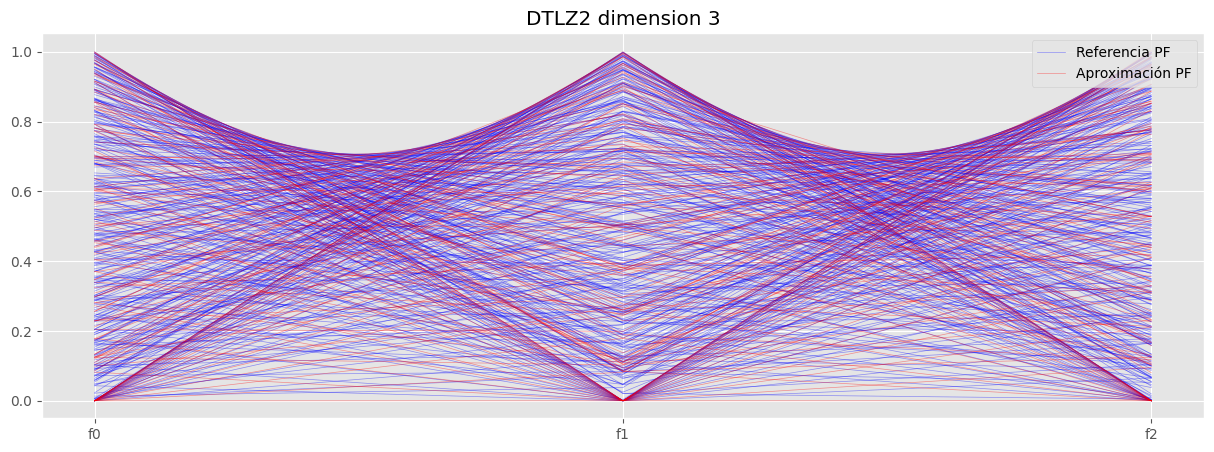

In [12]:
diag_probl(problema='DTLZ2',n_objetivos=3,indicador='spd',df_PI=df_todos_PI_IGDp)
# df_borda.loc[190]

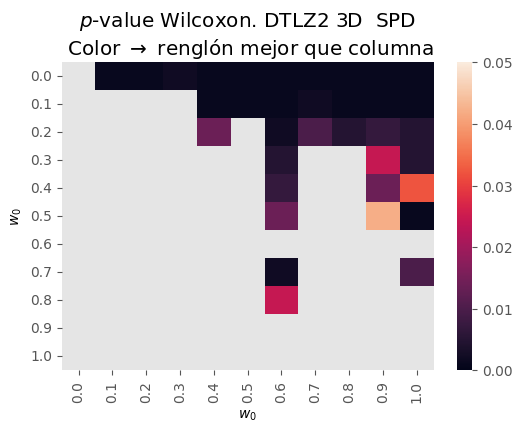

In [14]:
df_WC=pd.read_csv('../tablas_generadas/WC_QI_v2.csv')
df_WC=df_WC.set_index(['n_objetivos','problema','indicador']).iloc[:,1:]


get_heatmap(problema='DTLZ2',n_objetivos=3,indicador='spd',df_todos_PI=df_todos_PI_IGDp,df_WC=df_WC_IGDp);

Corremos para w_0=[0,1], w_0=[1,0]. Debería de dar diferentes resultados

In [18]:
pd.read_csv('../../tablas_generadas/problemas_prueba.csv').query('(problemas=="DTLZ2") & (n_obj==3)')

,problemas,n_obj,n_var,n_pos
8,DTLZ2,3,12,4


In [19]:
ws=[(0,1),(1,0)]

for i,wi in enumerate(ws):
    ejecutar_algoritmo_con_input(w_comb=wi,label=f'100{i}',n_obj=3,n_var=12,wfg_npos=4,problema_prueba='DTLZ2')

Ejecutando comando
./pcuiemoa input/Param_03D-1000.cfg DTLZ2 10 augmented_chebyshev_pcui IGD+ ES
----------------------------------------------------------------------------------------------------
log tmp PCUI-EMOA_ATCH_IGD+_ES_DTLZ2_0.log
PCUI-EMOA
Combination utility function:
Utility: augmented_chebyshev_pcui
Using w_comb = (0.000000, 1.000000)
Random inicialization of population.
mu 120, var 12, obj 3
Codificacion real
caso 1 = 834   caso 2 = 26875
Random inicialization of population.
mu 120, var 12, obj 3
Codificacion real
caso 1 = 855   caso 2 = 26837
Random inicialization of population.
mu 120, var 12, obj 3
Codificacion real
caso 1 = 784   caso 2 = 27173
Random inicialization of population.
mu 120, var 12, obj 3
Codificacion real
caso 1 = 776   caso 2 = 27375
Random inicialization of population.
mu 120, var 12, obj 3
Codificacion real
caso 1 = 820   caso 2 = 26766
Random inicialization of population.
mu 120, var 12, obj 3
Codificacion real
caso 1 = 848   caso 2 = 26842
Random 

In [20]:
def get_sol_path(path, n_objetivos):
    '''Obtener df de la solución '''
    go_to_PCUI_Proyect()


    df = pd.read_csv(path, sep=" ").reset_index().iloc[:, :n_objetivos]
    df.columns = [f"f{i}" for i in range(len(df.columns))]
    return df


In [22]:
w_01=get_sol_path(path='./demo/output/PCUI-EMOA_ATCH_IGD+_ES_WFG5_03D_1000W_R01.pof',n_objetivos=3)
w_10=get_sol_path(path='./demo/output/PCUI-EMOA_ATCH_IGD+_ES_WFG5_03D_1001W_R01.pof',n_objetivos=3)
pareto_wfg5=conjunto_pareto(problema='WFG5',n_objetivos=3)


trace_set2 = go.Scatter3d(
    x=w_01["f0"],
    y=w_01["f1"],
    z=w_01["f2"],
    mode="markers",
    marker=dict(
        size=5,
        color="red",
        opacity=0.7,
    ),
    name="Aproximación PF w_0=0",
)

trace_set3 = go.Scatter3d(
    x=w_10["f0"],
    y=w_10["f1"],
    z=w_10["f2"],
    mode="markers",
    marker=dict(
        size=5,
        color="green",
        opacity=0.7,
    ),
    name="Aproximación PF w_0=1",
)

layout = go.Layout(
    scene=dict(
        xaxis=dict(title="f0"), yaxis=dict(title="f1"), zaxis=dict(title="f2")
    ),
    margin=dict(l=0, r=0, b=0, t=0),
)
fig = go.Figure(data=[trace_set2,trace_set3], layout=layout)
fig.update_layout(
    title=f"Aproximación al frente de Pareto run",
    height=500,
    width=500,
)

fig.show()

Se encontró el conjunto de referencia en Assessment


son los mismos

Si haces 100 experimentos de comparación entre normales, cuántas de ellas realmente resultan ser rechazadas sólo por azar de la prueba?

# Demostración de Wilcoxon

Vemos cómno funciona la prueba de Wilcoxon en `statmodels` con un ejemplo en el que generamos dos normales con medias distintas.

La hipótesis nula de la prueba de Wilcoxon en sklearn es que la alternativa no se cumple. En la siguiente instrucción
```py
st.wilcoxon(gauss_5,gauss_0,alternative='less')
``` 
la hipótesis nula es que la serie `gauss_5` tiene menor media que `gauss_0`. Como esto no ocurre **no se rechaza la hipótesis nula**, es decir `gauss_5` no es menor a `gauss_0`.

Por otro lado si se cambia la alternativa 
```py
st.wilcoxon(gauss_5,gauss_0,alternative='greater')
```
entonces si se rechazará la hipótesis nula queriendo decir que `gauss_5` si es menor a `gauss_0`

Con less:  WilcoxonResult(statistic=500500.0, pvalue=1.0)
Con greater:  WilcoxonResult(statistic=500500.0, pvalue=1.6629295594672565e-165)


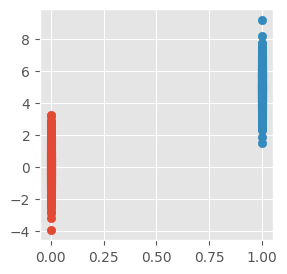

In [ ]:
gauss_0=np.random.normal(loc=0,size=1000)
gauss_5=np.random.normal(loc=5,size=1000)

plt.figure(figsize=(3,3))
plt.scatter(np.zeros(1000),gauss_0)
plt.scatter(np.ones(1000),gauss_5)
print('Con less: ',st.wilcoxon(gauss_5,gauss_0,alternative='less')) # Vemos que no se rechaza la hipótesis nula, es decir gauss_5 no es menor que gauss_0
print('Con greater: ',st.wilcoxon(gauss_5,gauss_0,alternative='greater')) # Vemos que se rechaza la hipótesis nula, es decir gauss_5-gauss_0 es mayor que 0


Para entender bien wilcoxon hacer una series de pruebas donde la mediana esté por arriba o por abajo y sea mejor o peor